## Credit Risk Prediction with XGBoost

### Objective:

- Build an XGBoost classifier to predict credit default based on a given dataset.

In [1]:
!pip install xgboost

In [2]:
#Import necessary libaries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [3]:
#Load the dataset
url = 'https://github.com/Safa1615/Dataset--loan/blob/main/bank-loan.csv?raw=true'
data = pd.read_csv(url, nrows=700)

# DATA EXPLORATION

In [4]:
print(data.columns)

# Display the first few rows of the dataset
display(data.head())

# Summary statistics of the dataset
display(data.describe())

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1
1,27,1,10,6,31,17.3,1.362202,4.000798,0
2,40,1,15,14,55,5.5,0.856075,2.168925,0
3,41,1,15,14,120,2.9,2.658720,0.821280,0
4,24,2,2,0,28,17.3,1.787436,3.056564,1


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,34.860000,1.722857,8.388571,8.278571,45.601429,10.260571,1.553553,3.058209,0.261429
std,7.997342,0.928206,6.658039,6.824877,36.814226,6.827234,2.117197,3.287555,0.439727
min,20.000000,1.000000,0.000000,0.000000,14.000000,0.400000,0.011696,0.045584,0.000000
25%,29.000000,1.000000,3.000000,3.000000,24.000000,5.000000,0.369059,1.044178,0.000000
50%,34.000000,1.000000,7.000000,7.000000,34.000000,8.600000,0.854869,1.987567,0.000000
75%,40.000000,2.000000,12.000000,12.000000,55.000000,14.125000,1.901955,3.923065,1.000000
max,56.000000,5.000000,31.000000,34.000000,446.000000,41.300000,20.561310,27.033600,1.000000


In [5]:
#see any null values in columns as well as column types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       700 non-null    int64  
 1   ed        700 non-null    int64  
 2   employ    700 non-null    int64  
 3   address   700 non-null    int64  
 4   income    700 non-null    int64  
 5   debtinc   700 non-null    float64
 6   creddebt  700 non-null    float64
 7   othdebt   700 non-null    float64
 8   default   700 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 49.3 KB


I am not seeing any null or missing values here so no need to handle that. Below i am looking at the corr matrix and nothing seems to be too heabily influenced on defauly. However, income, debtinc, creddebt and othdebt seem to share strong corelations which makes sense.

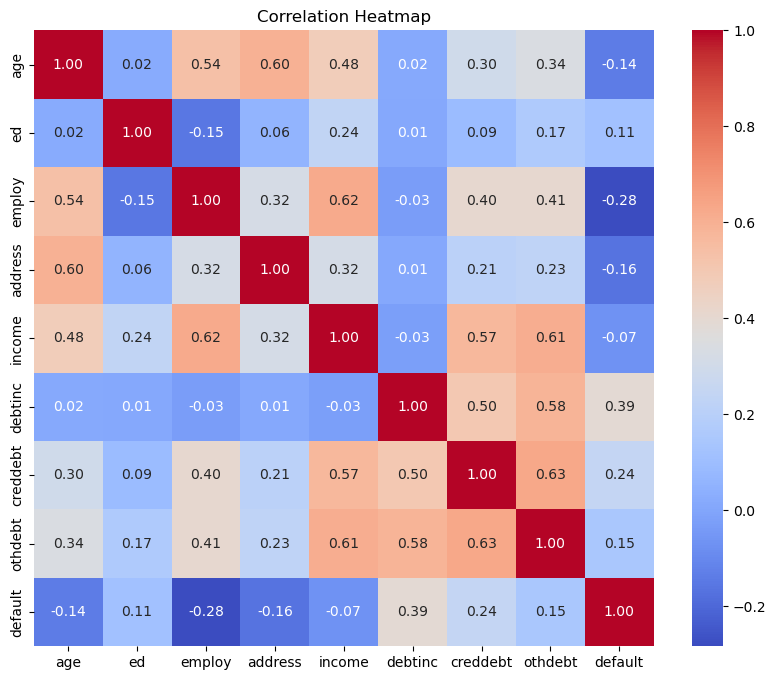

In [6]:
# Create a heatmap to visualize correlation between numeric variables
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

/Users/skodati/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


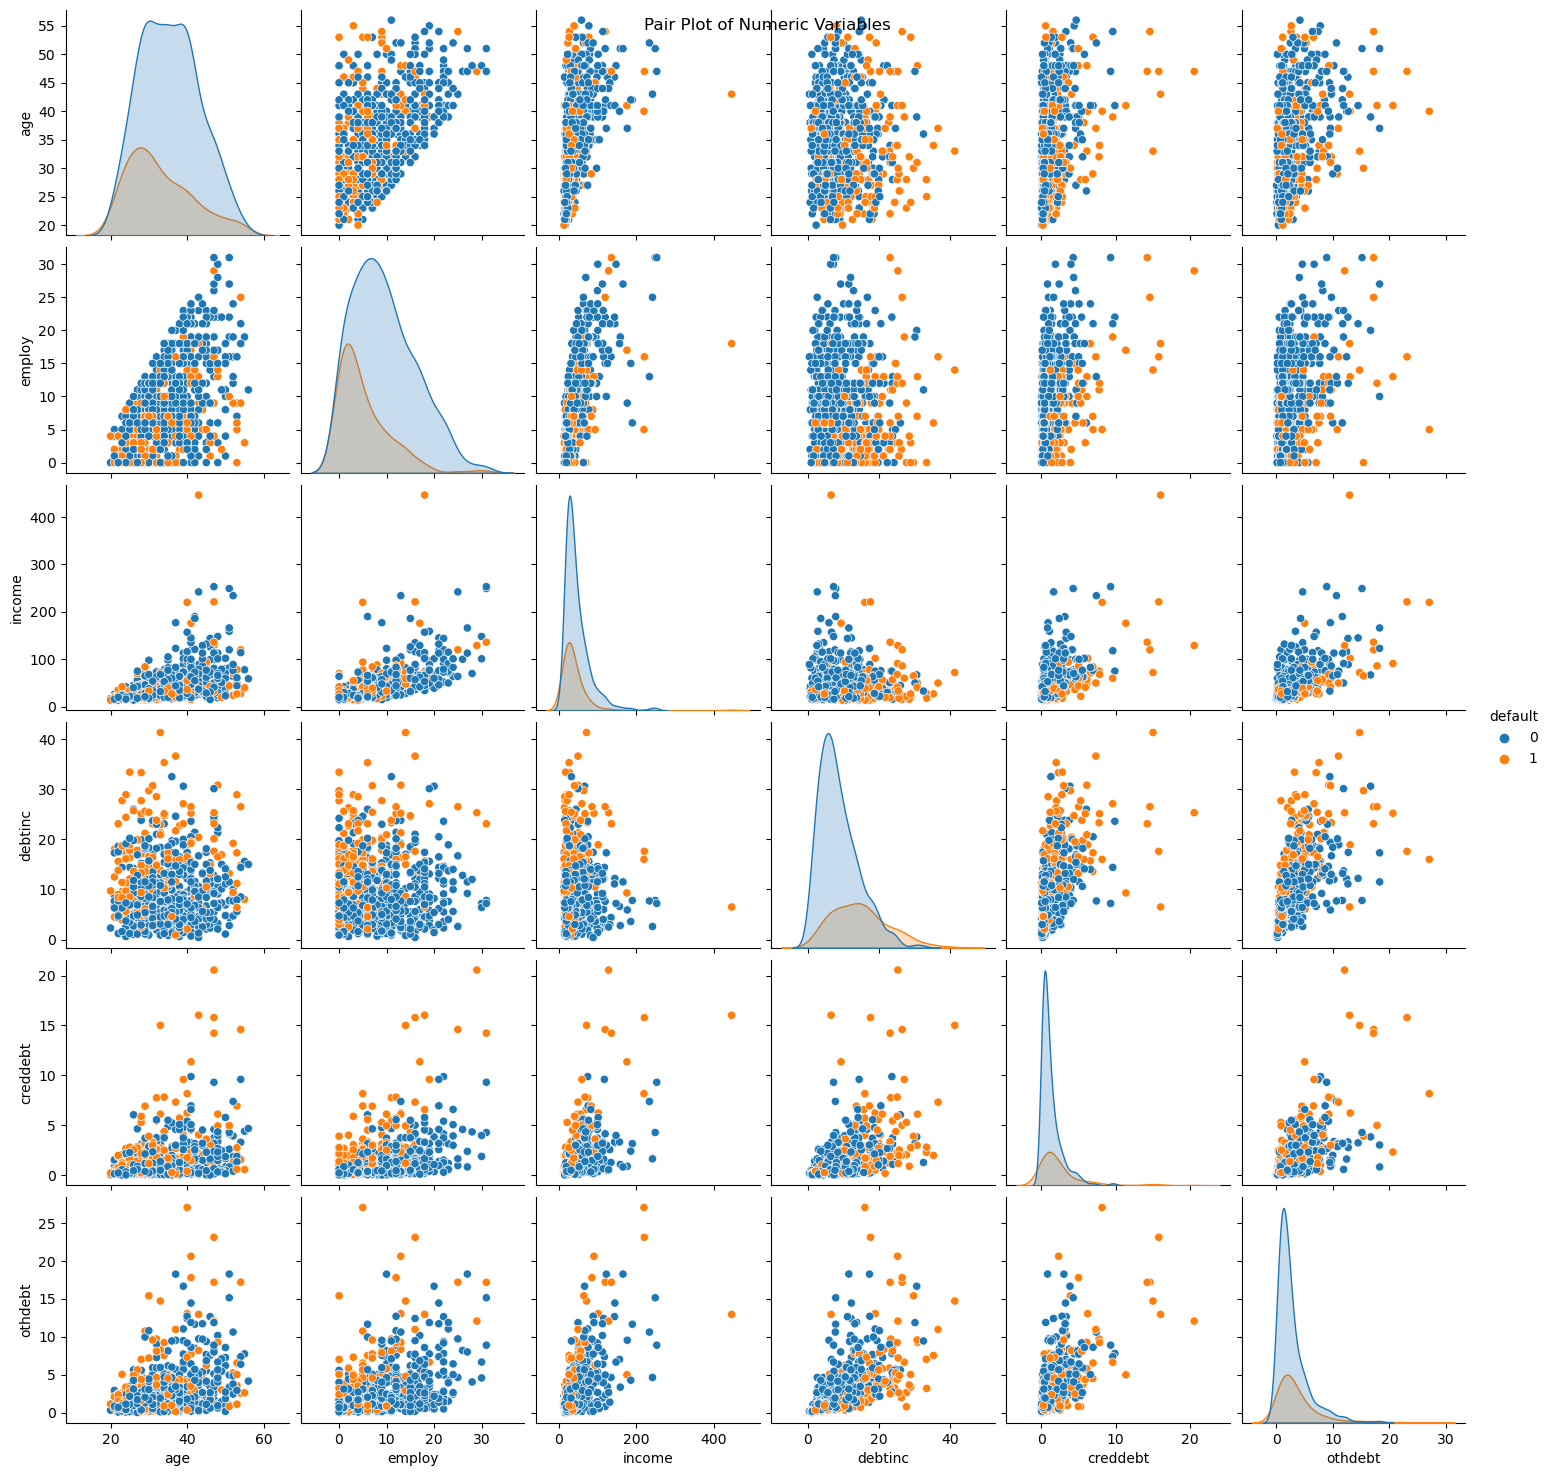

In [7]:
# Create a pair plot to visualize relationships between numeric variables
sns.pairplot(data, vars=['age', 'employ', 'income', 'debtinc','creddebt','othdebt'], hue='default')
plt.suptitle("Pair Plot of Numeric Variables")
plt.show()

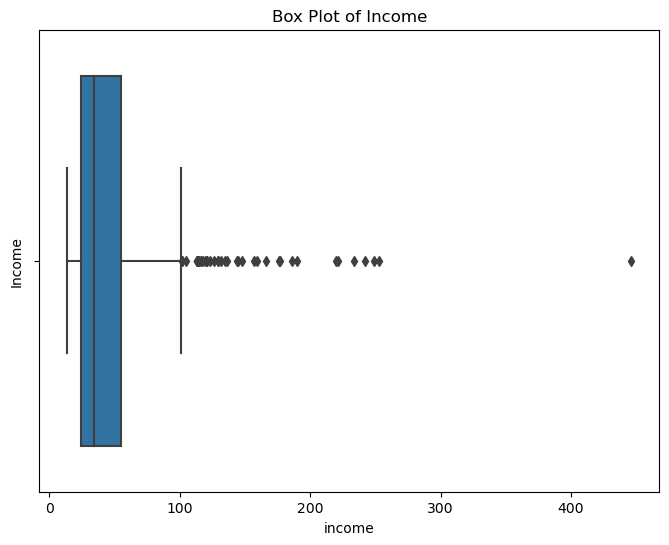

In [8]:
# Create a box plot to visualize the distribution of 'income'
plt.figure(figsize=(8, 6))
sns.boxplot(x='income', data=data)
plt.title("Box Plot of Income")
plt.ylabel("Income")
plt.show()

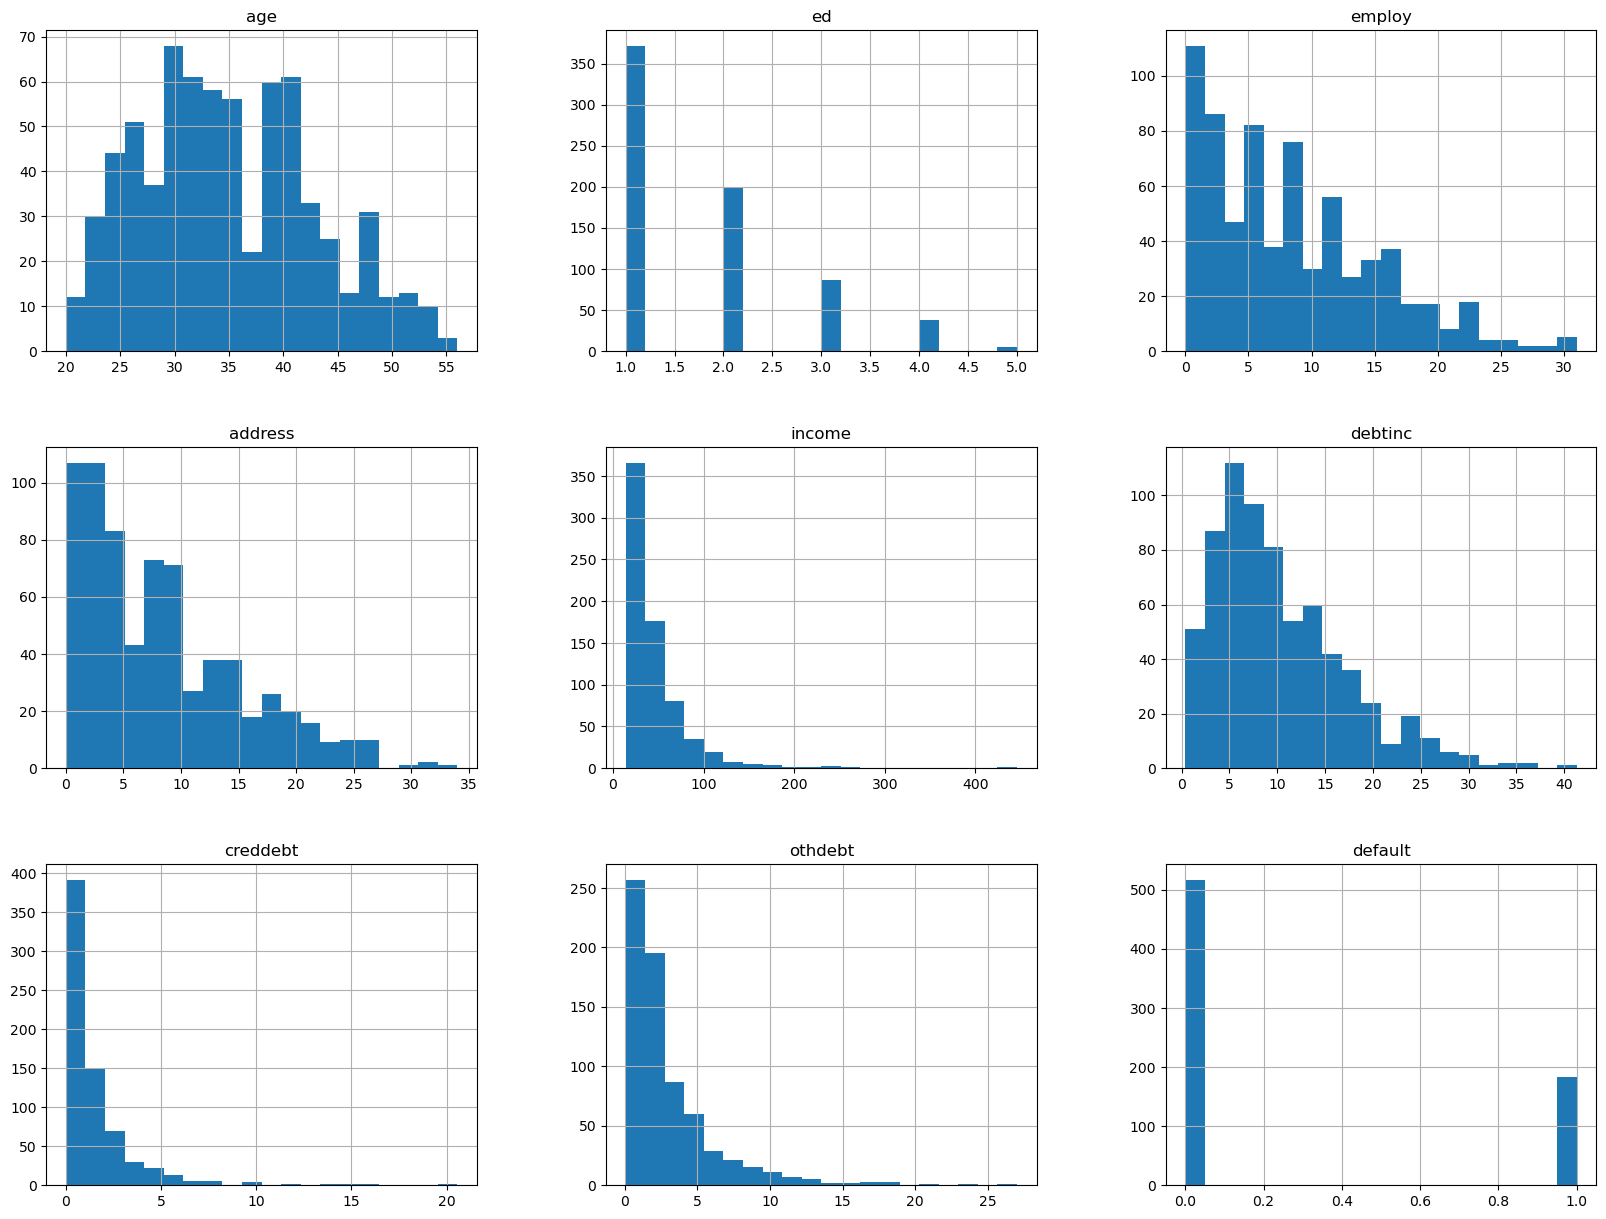

In [9]:
#create a visualization of histograms for all columns to see if any are tailed heavy or uniformly distributed
data.hist(bins = 20,figsize = (20,15))
plt.show()

# PREPROCESSING

I am seeing a few things from this graph

1. Everything is on a different scale so ill have to scale all the attributes 
2. The debt variables are left tailed but have a small scale so it shouldnt be too effective on the model
3. However the income is extremelty left tailed and has a large scale. I would think of replacing the numeric values with categorical numeric values. Not sure if this should be done though.

In [10]:
#Split the data into features (independent variables) and the target variable (default or not)
X = data.drop('default', axis=1)
y = data['default']

#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Apply standard scaler on X data
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# XGBOOST IMPLEMENTATION

In [11]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred = xgb_classifier.predict(X_test)

In [13]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

#Print the results
print(f"Accuracy: {accuracy: .2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)

Accuracy:  0.79
Confusion Matrix:
[[89 13]
 [17 21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       102
           1       0.62      0.55      0.58        38

    accuracy                           0.79       140
   macro avg       0.73      0.71      0.72       140
weighted avg       0.78      0.79      0.78       140



# GRID SEARCH CV

A 79% accuracy and 86% f-score is not bad but this can definitely be fine tuned. I know the default params for n_estimatirs is 500, max_depth is 3 and learning rate is 0.1. Lets create a param list where each of these has some value below and above the standard tresholds.

Then we can perform a GridSearch CV

In [14]:
xgb_params = {"n_estimators":[300, 500,1000,2000,3000],
              "max_depth":[1,2,3,4,5,6],
              "learning_rate":[0.01,0.1,0.02]
             }

In [15]:
xgb_cv_model = GridSearchCV(xgb_classifier,xgb_params).fit(X_train , y_train)

In [16]:
xgb_cv_model.best_params_

{'learning_rate': 0.02, 'max_depth': 1, 'n_estimators': 2000}

# BEST FIT MODEL

Here we can see the best performance hyperparameters. We see that max_depth was below the standard, n_estimators well above, and learning rate slightly higher. We can apply this to a new model and try it out.

In [17]:
xgb_classifier_best = xgb.XGBClassifier(learning_rate = 0.02, max_depth= 1, n_estimators= 2000, random_state = 42)
xgb_classifier_best.fit(X_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [18]:
y_predicted_best = xgb_classifier_best.predict(X_test)

In [19]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_predicted_best)
confusion = confusion_matrix(y_test, y_predicted_best)
classification_rep = classification_report(y_test, y_predicted_best)

#Print the results
print(f"Accuracy: {accuracy: .2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)

Accuracy:  0.85
Confusion Matrix:
[[97  5]
 [16 22]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       102
           1       0.81      0.58      0.68        38

    accuracy                           0.85       140
   macro avg       0.84      0.76      0.79       140
weighted avg       0.85      0.85      0.84       140



We imporved the model to 85% accuracy and a 90% f-1 score. NICE!

# TAKEAWAYS AND REFLECTION

Overall, it seems xgboost does provide better accuracy than random forrest. This makes sence since boosting is better to reduce the bias. We are using a small dataset too so the gradient boosting does have a greater effect. For a large dataset, random forrest may or may not perfom better but with xgboost we do have greater control of hyperparameters. With this model, we can see if users are credit risks or not with better accuracy than our random forrest model. In finance, the f1 score difference is huge. We arent just creating models for better stats, but these models are used in real life to determine if one can get a home loan, a student loan or finance a new business. The optimizations and impleemntations of these models has to be done with the upmost care and detail. 